In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#### Helper functions

In [24]:
# Create TS-data with the given parameters
def create_ts_data(length, slope = 1, offset = 0, start="2019-01-01", noise=False, sd=0.01):
    
    # Create the date range
    start_date = pd.to_datetime(start)
    dates = pd.date_range(start_date, freq="D", periods=length)
    
    # Create the data
    data = offset + slope * np.arange(length).astype("float32")
    
    # Optionally add gaussian noise
    if noise is True:
        data = data + np.random.normal(0, sd, length)
    
    result = pd.DataFrame({"date" : dates, "data": data})
    result.set_index("date", inplace=True)
    return result    



# Create lagged features as given in list
def create_train_from_ts(df: pd.DataFrame, lags: list, target: str) -> pd.DataFrame: 
    
    # Extract the relevant variable (the actual timeseries) from the data
    data = df.loc[:, target]
    
    # Collect the features
    lagged_features = dict()
    for lag in lags:
        lagged_features[f"lag_{lag}"] = data.shift(lag)
          
    # concat to a new df.
    return df.assign(**lagged_features)


# Split the data into train and test without data leakage.
def split_train_test(df: pd.DataFrame, start_test: str, max_lag: int,  target: str) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):
    
    # First remove leading rows with NA. We are going to assume that there are no additional NA's in the DataFrame.
    df.dropna(inplace=True)
    
    # The end of the training will start_test - max_lags to avoid data leakage.
    start_test = pd.to_datetime(start_test) 
    end_train = start_test - pd.DateOffset(max_lag)
    
    training_data = df.loc[df.index < end_train, :]
    testing_data = df.loc[df.index >= start_test, :]
    
    return (training_data[[col for col in training_data.columns if col != target]],
            testing_data[[col for col in testing_data.columns if col != target]],
            training_data.loc[:, [target]],
            testing_data.loc[:, [target]])

### Using random Forests to predict time-series with a strong trend

In this notebook, I want to investigate whether using 

## Parameters

In [25]:
# Parameters concerning the data Creation.

# Steepnes of the data
slope = 1 

# Offset at the beginning
offset = 0

# Should there be Gaussian noise in the data?
noise = True

# Standard devation of the Gaussian noise
sd = 5


# Start of the time-series
start_data = "2019-01-01"

# Start of the validation-period
start_validation = "2019-08-01"

# length of the time-series
length_time_series = 356

# Variable name of the time series column
target = "data"

Let's first simulate the data, create the features and split it.

In [16]:
# Simulate the data
data = create_ts_data(length = length_time_series, slope = slope, offset = offset, start=start_data, noise=noise, sd=sd)

# Create the lagged features
df_lagged_features = create_train_from_ts(df=data, lags=[1], target=target)

# Split the data
X_train, X_test, y_train, y_test = split_train_test(df_lagged_features, start_test=start_validation, max_lag=1, target=target)

Now let's fit the regression and the random forest and create there predictions.

In [17]:
# Fit the linear regression to the data
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train.values.reshape(-1))

# Create predictions
y_pred_linear_regression = y_test.copy()
y_pred_linear_regression.loc[:, "data"] = linear_regression.predict(X_test.values)

In [31]:
linear_regression.coef_

array([0.99389757])

In [18]:
# Fit the random forest to the data
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train.values.reshape(-1))

# Create the predictions
y_pred_random_forest= y_test.copy()
y_pred_random_forest.loc[:, "data"] = random_forest.predict(X_test.values)

Let's have a look at the dataset and evaluate the predictions

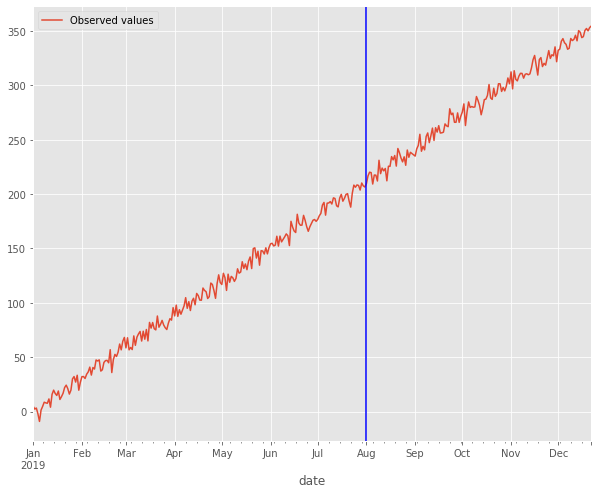

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
data.plot(ax=ax)

ax.axvline(start_validation, data.data.min(), data.data.max(), label="Begin validation", color="Blue")

ax.legend(labels = ["Observed values"])

### Prediction of the Linear regression

Text(0.5, 1.0, 'Precictions of the Linear regression')

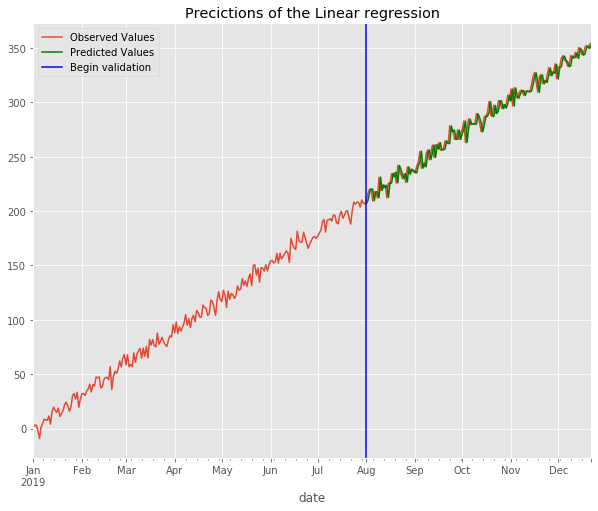

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
data.plot(ax=ax, label="Observed Values")

y_pred_linear_regression.plot(ax=ax, color="green", label="Prediction")

ax.axvline(start_validation, data.data.min(), data.data.max(), label="Begin validation", color="Blue")

ax.legend(labels = ["Observed Values", "Predicted Values", "Begin validation"])
ax.set_title("Precictions of the Linear regression")

Prediction of the Random forest

Text(0.5, 1.0, 'Precictions of the random forest')

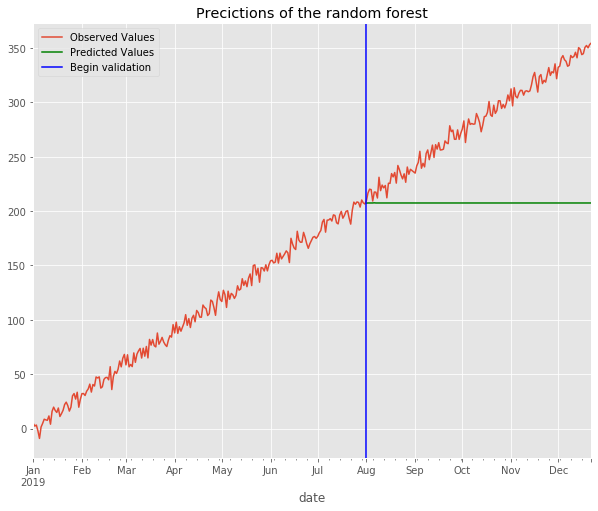

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))
data.plot(ax=ax)

y_pred_random_forest.plot(ax=ax, color="green")

ax.axvline(start_validation, data.data.min(), data.data.max(), label="Begin validation", color="Blue")

ax.legend(labels = ["Observed Values", "Predicted Values", "Begin validation"])
ax.set_title("Precictions of the random forest")

### Results

Overall it shows clearly that the random forest cannot predict the trend in the data. This does also make sense. The underlying trees of the random forest can only give you average values of the training data that it segmented in some way.Therefore it cannot predict values higher than the highest value in the traning period. The fact that is appears that the random forest actually only precicts the highest value it observed is a good sign and is the best prediction it can give.